### Micrograd
Framework for creating computational graphs with forward and backward pass computations for automatic differentiation. Simplified version of the framework used in pytorch library (the class names and structure are similar)

In [61]:
# %conda install python-graphviz

Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 23.9.0

Please update conda by running

    $ conda update -n base -c defaults conda





Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\aditisingh\Miniconda3\envs\py310

  added / updated specs:
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       haa95532_0         123 KB
    cairo-1.16.0               |       he04af86_2         1.5 MB
    certifi-2023.7.22          |  py310haa95532_0         154 KB
    expat-2.5.0                |       hd77b12b_0         225 KB
    fribidi-1.0.10             |       h62dcd97_0          63 KB
    getopt-win32-0.1           |       h2bbff1b_0          19 KB
    glib-2.69.1                |       h5dc1a3c_2         1.8 MB
    graphite2-1.3.14           |       hd77b12b_1          91 KB
    graphviz-2.50.0            |       hdb8b0d4_0         903 KB
    gts-0.7.6                  |       h63ab5a1_3         181 KB
    harfbuzz-4.3.0          

In [276]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [271]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.label=label
        self.grad=0.0
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __neg__(self):
        return self *-1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad = other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self*other**-1
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):  
        visited = set()
        topo = []
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

In [262]:
a = Value(5.0, label='a')
b = Value(-6, label='b')
c = Value(10, label='c')
d = a*b; d.label='d'
e = d+c; e.label='e'
f = e.tanh(); f.label='f'
g = Value(-2, label='g')
L = f*g; L.label='L'
6 + (-L)**3

Value(data=-2.0)

In [263]:
L.grad = 1
# e._backward()
L.backward()

[Value(data=-6), Value(data=5.0), Value(data=-30.0), Value(data=10), Value(data=-20.0), Value(data=-1.0), Value(data=-2), Value(data=2.0)]
how many tym 1.0
how many tym -1.0
how many tym -2.0
how many tym 0.0
how many tym 0.0
how many tym 0.0
how many tym 0.0
how many tym 0.0


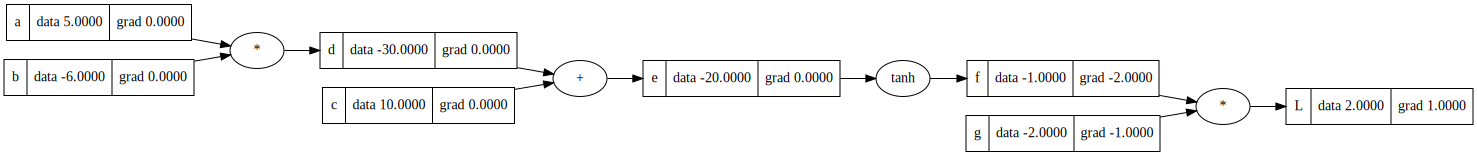

In [265]:
draw_dot(L)
# kills gradients

In [128]:
# building visualization for the computational graph
import os
os.environ["PATH"] += os.pathsep + 'C:/users/aditisingh/miniconda3/envs/py310/lib/site-packages/'

from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, shape='record', label="{ %s | data %.4f | grad %.4f}"%(n.label, n.data, n.grad))
        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

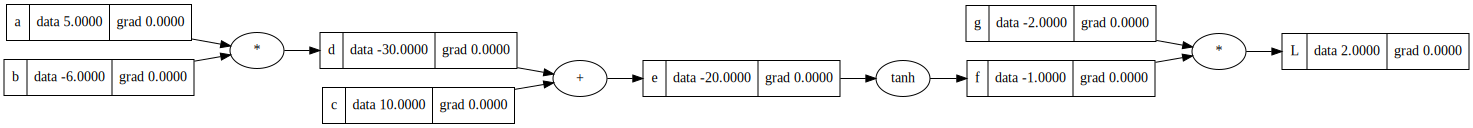

In [147]:
draw_dot(L)

## Understanding Gradients

Addition

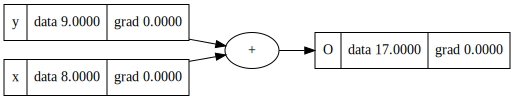

In [130]:
x = Value(8, label='x')
y = Value(9, label='y')
o = x+y; o.label='O'
draw_dot(o)

In [134]:
o.grad = 1
x.grad = 1 # d(x+y)/dx
y.grad = 1 # d(x+y)/dy

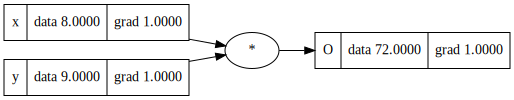

In [135]:
draw_dot(o)

Multiplation

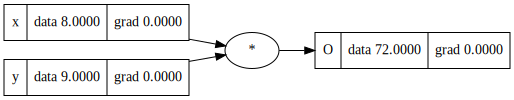

In [136]:
x = Value(8, label='x')
y = Value(9, label='y')
o = x*y; o.label='O'
draw_dot(o)

In [137]:
o.grad = 1
x.grad = 9# dxy/dx
y.grad = 8# dxy/dy

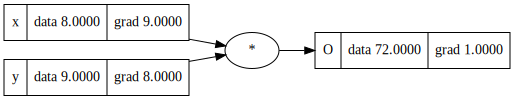

In [138]:
draw_dot(o)

In [ ]:
compound function

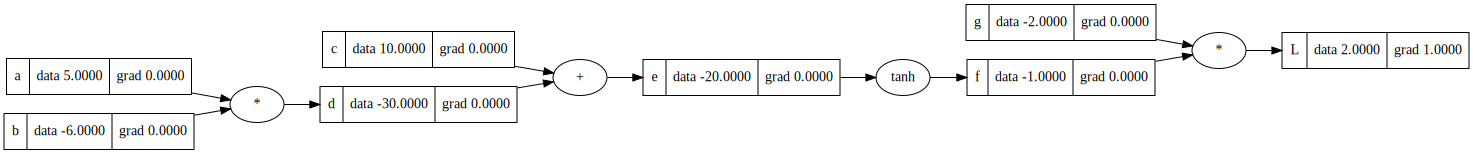

In [187]:
draw_dot(L)

$$ \frac{dL}{dL} = 1 $$
$$ \frac{dL}{dg} =  $$
$$ \frac{dL}{df} =  $$
$$ \frac{dL}{de} =  \frac{dL}{df}*\frac{df}{dg}$$
$$ \frac{dL}{dd} =  \frac{dL}{de}*\frac{de}{dd} = \frac{dL}{df}*\frac{df}{dg}*\frac{de}{dd} $$

In [186]:
L.grad = 1
# g._backward()
# f._backward()
L.backward()

In [ ]:
L.grad = 1
g.grad = -2 # dL/dg
f.grad = # dL/df
e.grad = # dL/de = dL/df*dg/df
d.grad = # dL/dd = dL/de*de/dd
c.grad = # dL/dc = 
b.grad = # dL/db = 
a.grad = # dL/da

In [149]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

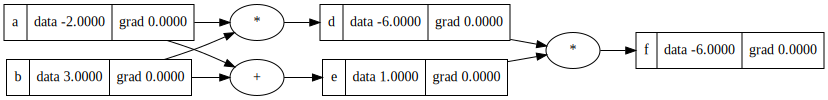

In [150]:
draw_dot(f)

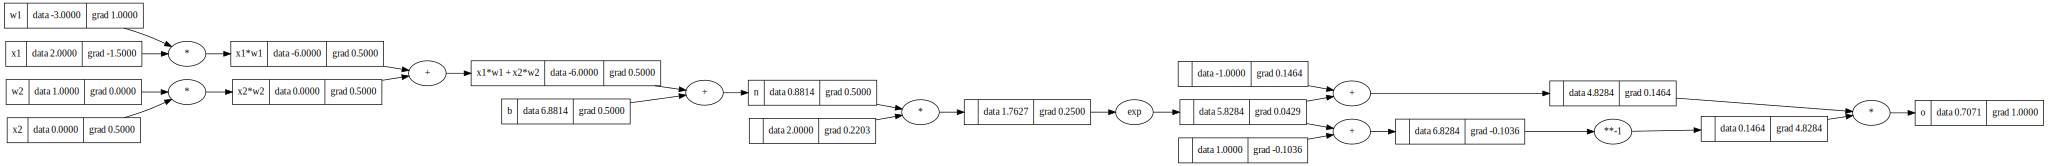

In [272]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

problem with the tanh function - kills all the gradients

creating neurons
neuron single unit with weight and bias
layers = collection of neurons
mlp - connection of layers

In [298]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1), label=f'w{i}') for i in range (nin)]
        self.b = Value(random.uniform(-1, 1), label='b')
        
    def __call__(self, x):
        # sums(w*x) + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [308]:
x = [2.0, 3.0]
n = Neuron(3)
n(x), n.parameters

(Value(data=-0.7138059481011649),
 <bound method Neuron.parameters of <__main__.Neuron object at 0x000001E9C367E080>>)

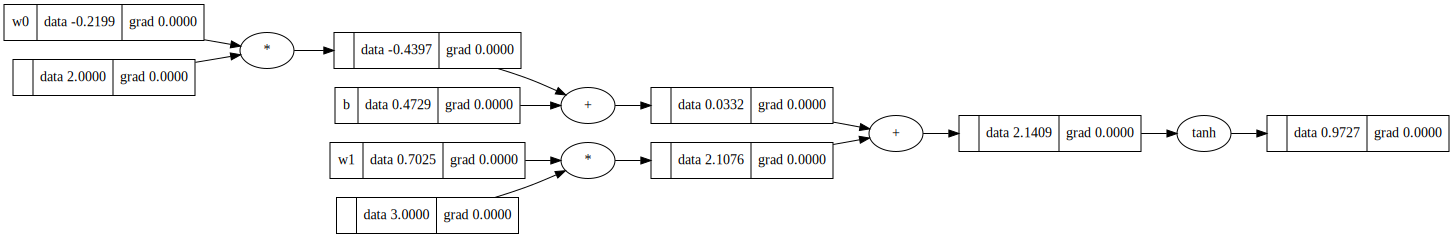

In [306]:
draw_dot(n(x))

In [336]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [337]:
x = [2, 3]
n = Layer(2, 3)
n(x)

[Value(data=0.9972120013444591),
 Value(data=-0.9823949538820566),
 Value(data=-0.792835861560736)]

In [312]:
# draw_dot(n(x))

In [320]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [342]:
x = [2, 3, 5]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7084056985467692)

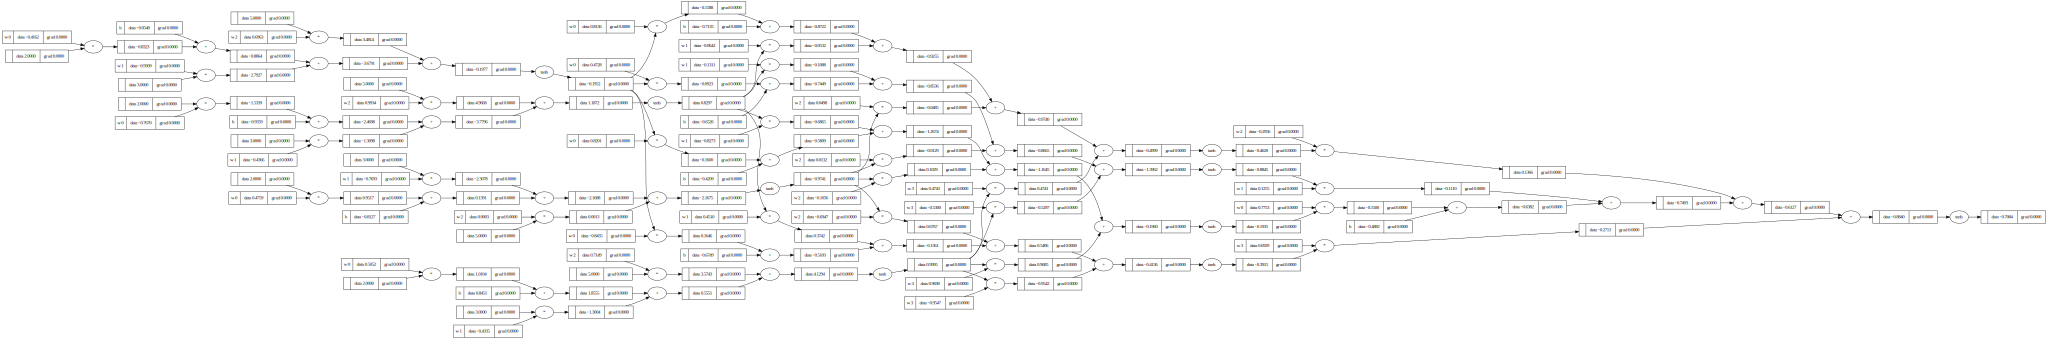

In [343]:
draw_dot(n(x))

neural network ready

In [347]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.29066215010175644),
 Value(data=-0.5164884311436803),
 Value(data=-0.4038183997426063),
 Value(data=-0.3571117466647064)]

In [348]:
loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
loss

Value(data=4.096777016343986)

In [350]:
epochs = 10

for k in range(epochs):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
    
    # backward pass
#     intializate grads -after the data has been updated, the grads chg - and we should flush oout the old ones
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update parameters
    for p in n.parameters():
        p.data += -0.1*p.grad
        
    print(k, loss.data)

0 15.827557120949558
1 15.800504808209553
2 15.764573402874946
3 15.714867228556244
4 15.64228677795802
5 15.52796791200401
6 15.325586308032953
7 14.87386388428503
8 12.243389019275826
9 7.079665517342194


In [351]:
ypred

[Value(data=0.9449358580151824),
 Value(data=0.854829864785293),
 Value(data=0.9060296259797831),
 Value(data=0.9426354186138343)]

In [352]:
n.parameters()

[Value(data=0.12500297835893098),
 Value(data=-0.7833432780001683),
 Value(data=0.8542472174291917),
 Value(data=0.33250695464092994),
 Value(data=-0.8056058090985406),
 Value(data=-0.4939492785976415),
 Value(data=0.9341071035340963),
 Value(data=-0.9985788621236621),
 Value(data=0.5737176998075297),
 Value(data=-0.6771318904728899),
 Value(data=-0.07326670721908812),
 Value(data=-0.7308572151521047),
 Value(data=1.3500903525506593),
 Value(data=0.6565529509609109),
 Value(data=0.15044594126330588),
 Value(data=1.4742137962390158),
 Value(data=0.6112236001240378),
 Value(data=-1.2361570669282216),
 Value(data=-0.3025275524394602),
 Value(data=1.4043452411599864),
 Value(data=0.0525657526498036),
 Value(data=0.5864391397742775),
 Value(data=-0.22219775275965),
 Value(data=0.1377074182545619),
 Value(data=-0.3910608443305322),
 Value(data=-0.5530313571812562),
 Value(data=0.8060111455222491),
 Value(data=-0.14635189779619032),
 Value(data=0.056725733561521635),
 Value(data=0.51948244044